# Make figures for Lecture 2: Isostasy and Plate Flexure

This notebook uses the data in the `data` folder to make figures for the first lecture. Some require data processing as well.

## General instructions

This is a [Jupyter notebook](https://jupyter.org/) running in [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/). The notebook is a programming environment that mixes code (the parts with `[1]: ` or similar next to them) and formatted text/images/equations with [Markdown](https://www.markdownguide.org/basic-syntax) (like this part right here).

Quick start guide:

* **Edit** any cell (blocks of code or text) by double clicking on it.
* **Execute** a code or Markdown cell by typing `Shift + Enter` after selecting it.
* The current active cell is the one with a **blue bar next to it**.
* You can run cells **in any order** as long as the code sequence makes sense (it's best to go top-to-bottom, though).
* To copy any file to the current directory, drag and drop it to the file browser on the left side.
* Notebook files have the extension `.ipynb`.

## Import things

As always, start by importing the packages that we need.

In [1]:
import bz2
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean
import cartopy.crs as ccrs
import verde as vd
# Gravity and magnetics processing and modelling
import harmonica as hm
# Geodetic ellipsoids and their gravity
import boule as bl

## Profile of topography/bathymetry

Plot a map of Earth relief with a profile location and extract a profile across the Altantic to see what it looks like.

In [2]:
topo = xr.open_dataarray("../../data/earth_relief_10m.grd")
topo

<xarray.DataArray 'z' (lat: 1081, lon: 2161)>
[2336041 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -180.0 -179.8 -179.7 -179.5 ... 179.7 179.8 180.0
  * lat      (lat) float64 -90.0 -89.83 -89.67 -89.5 ... 89.5 89.67 89.83 90.0
Attributes:
    long_name:     elevation (m)
    actual_range:  [-10399.   6280.]

To extract the profile might take a long time because there are a lot of data to interpolate. To speed things up, we first coarsen the dataset using a blocked mean.

In [3]:
interpolator = vd.Chain([
    ("blockmean", vd.BlockReduce(np.mean, spacing=0.5)),
    ("interpolate", vd.ScipyGridder(method="nearest"))
])    

In [4]:
interpolator.fit(np.meshgrid(topo.lon, topo.lat), topo.values)

Chain(steps=[('blockmean',
              BlockReduce(adjust='spacing', center_coordinates=False,
                          drop_coords=True,
                          reduction=<function mean at 0x7f33dc89e3a0>,
                          region=None, shape=None, spacing=0.5)),
             ('interpolate', ScipyGridder(extra_args=None, method='nearest'))])

Now that the interpolator is fit on the data, we can use it to interpolate data on a profile.

In [5]:
profile_start = (-55, -10)
profile_end = (25, 0)
topo_profile = interpolator.profile(point1=profile_start, point2=profile_end, size=200)
# Convert the distance from degrees to kilometers
topo_profile.distance *= 111 
# And the topography from meters to kilometers
topo_profile.scalars /= 1000
print(topo_profile)

      northing   easting     distance   scalars
0   -10.000000 -55.00000     0.000000  0.282500
1    -9.949749 -54.59799    44.970382  0.407500
2    -9.899497 -54.19598    89.940765  0.364000
3    -9.849246 -53.79397   134.911147  0.331556
4    -9.798995 -53.39196   179.881530  0.345333
..         ...       ...          ...       ...
195  -0.201005  23.39196  8769.224571  0.435556
196  -0.150754  23.79397  8814.194953  0.434444
197  -0.100503  24.19598  8859.165336  0.438333
198  -0.050251  24.59799  8904.135718  0.487000
199   0.000000  25.00000  8949.106101  0.454833

[200 rows x 4 columns]


Plot the profile filling in between the lines with nice colors.

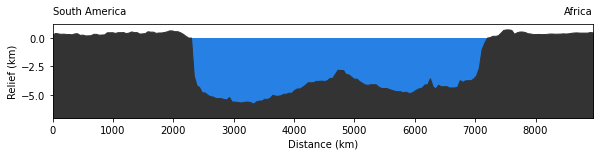

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.text(0, 1.1, "South America", transform=ax.transAxes)
ax.text(1, 1.1, "Africa", horizontalalignment="right", transform=ax.transAxes)
max_depth = -7
profile_bounds = [topo_profile.distance.min(), topo_profile.distance.max()]
ax.fill_between(profile_bounds, [0, 0], max_depth, color='#2780E3')
ax.fill_between(topo_profile.distance, topo_profile.scalars, max_depth, color='#333333')
ax.set_ylabel('Relief (km)')
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.ylim(max_depth, topo_profile.scalars.max() + 0.5)
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("topography-profile.png", dpi=200)
plt.show()

Plot the map again with the profile location for reference.

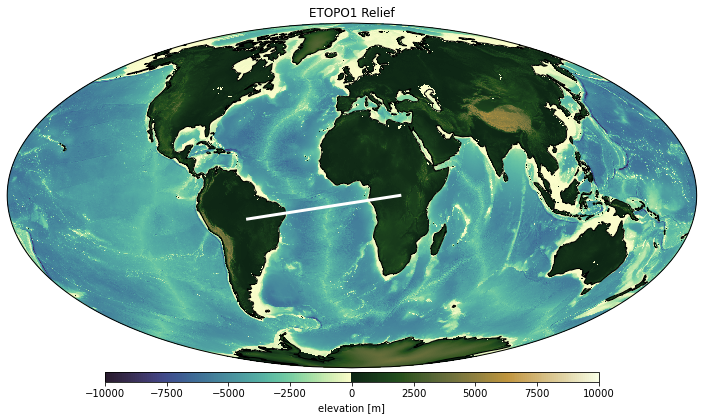

In [7]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_title("ETOPO1 Relief")
tmp = ax.pcolormesh(
    topo.lon, topo.lat, topo.values, 
    transform=ccrs.PlateCarree(), 
    vmin=-10000, vmax=10000, 
    cmap=cmocean.cm.topo
)
plt.colorbar(tmp, label="elevation [m]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.plot(topo_profile.easting, topo_profile.northing, "-w", linewidth=3, transform=ccrs.PlateCarree())
ax.coastlines()
plt.subplots_adjust(top=0.95, bottom=0, right=0.99, left=0.01, hspace=0, wspace=0)
plt.savefig("topography-profile-location.png", dpi=200)
plt.show()

## Hypothesis about the Moho depth

To exemplify using geophysics to test a hypothesis, we'll start by assuming that Moho is completely flat (constant depth). To test this hypothesis, we'll predict the gravity disturbance caused by it and check against actual data.

In [8]:
moho = -30 # km 
max_depth = -40 # bottom of the figure

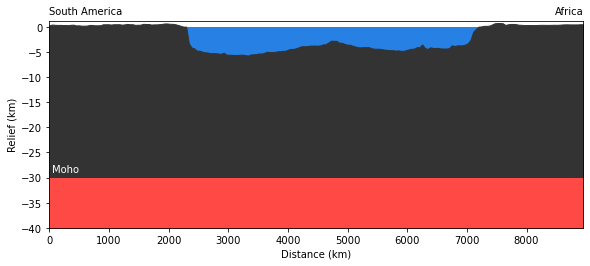

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.text(0, 1.03, "South America", transform=ax.transAxes)
ax.text(1, 1.03, "Africa", horizontalalignment="right", transform=ax.transAxes)
ax.text(50, -29, "Moho", color="white")
ax.fill_between(profile_bounds, [0, 0], moho, color='#2780E3')
ax.fill_between(topo_profile.distance, topo_profile.scalars, moho, color='#333333')
ax.fill_between(profile_bounds, [moho, moho], max_depth, color='#ff4945')
ax.set_ylabel('Relief (km)')
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.ylim(max_depth, topo_profile.scalars.max() + 0.5)
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("topography-profile-hypothesis.png", dpi=200)
plt.show()

Calculating the gravity disturbance starts (and ends) with subtracting the effect of the Normal Earth. The figure below represents the density of the this reference model.

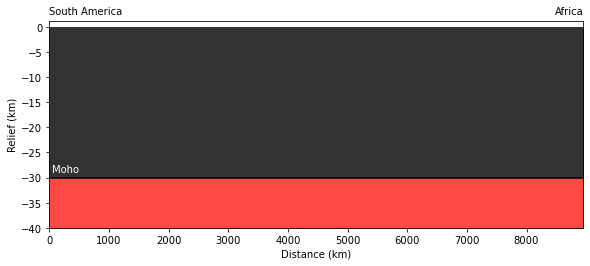

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.text(0, 1.03, "South America", transform=ax.transAxes)
ax.text(1, 1.03, "Africa", horizontalalignment="right", transform=ax.transAxes)
ax.text(50, -29, "Moho", color="white")
ax.plot(profile_bounds, [moho, moho], "-k")
ax.fill_between(profile_bounds, [0, 0], moho, color='#333333')
ax.fill_between(profile_bounds, [moho, moho], max_depth, color='#ff4945')
ax.set_ylabel('Relief (km)')
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.ylim(max_depth, topo_profile.scalars.max() + 0.5)
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("topography-profile-normal-earth.png", dpi=200)
plt.show()

Remove effects from the observed gravity is equivalent to removing density distributions from the subsurface. By removing the Normal Earth (above), all that is left from our flat-Moho model is the following:

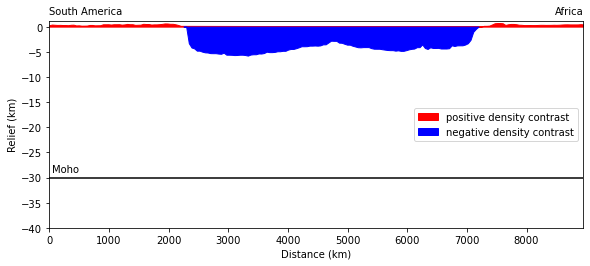

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.text(0, 1.03, "South America", transform=ax.transAxes)
ax.text(1, 1.03, "Africa", horizontalalignment="right", transform=ax.transAxes)
ax.text(50, -29, "Moho")
ax.plot(profile_bounds, [moho, moho], "-k")
continent = topo_profile.scalars > 0
ocean = np.logical_not(continent)
ax.fill_between(topo_profile.distance[continent], topo_profile.scalars[continent], 0, 
                color='red', label="positive density contrast")
ax.fill_between(topo_profile.distance[ocean], np.zeros_like(topo_profile.distance[ocean]), topo_profile.scalars[ocean], 
                color='blue', label="negative density contrast")
ax.set_ylabel('Relief (km)')
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.ylim(max_depth, topo_profile.scalars.max() + 0.5)
plt.legend(loc="center right")
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("topography-profile-disturbance.png", dpi=200)
plt.show()

Now we can use a Bouguer plate approximation to predict the gravity disturbance that would be measured if our hypothesis is correct. To do this, we use the anomalous density distribution shown above.

In [12]:
predicted_gravity = hm.bouguer_correction(topo_profile.scalars * 1000, density_crust=2800, density_water=1040)

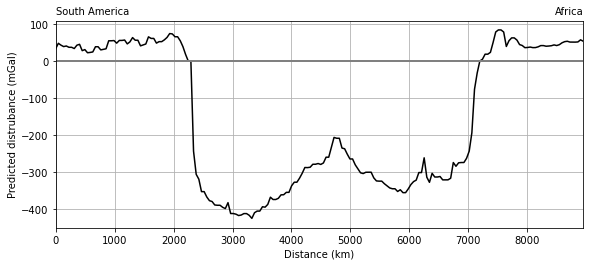

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.text(0, 1.03, "South America", transform=ax.transAxes)
ax.text(1, 1.03, "Africa", horizontalalignment="right", transform=ax.transAxes)
ax.plot(topo_profile.distance, predicted_gravity, "-k")
ax.plot(profile_bounds, [0, 0], "-", color="gray", linewidth=2)
ax.set_ylabel("Predicted distrubance (mGal)")
ax.grid()
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("gravity-profile-predicted.png", dpi=200)
plt.show()

## Gravity disturbances of the Earth

Now we have to check if our model fits actual observed data. To do that, let's load a grid of gravity observations. The data were generated from the spherical harmonic model EIGEN-6C4 at 10 km height above the ellipsoid, downloaded from [ICGEM](http://icgem.gfz-potsdam.de/). We'll use the library [Harmonica](https://www.fatiando.org/harmonica/latest/) to load the data.

In [14]:
with bz2.open("../../data/EIGEN-6C4-gravity-30m.gdf.bz2", "rt") as decompressed:
    gravity = hm.load_icgem_gdf(decompressed)
gravity

<xarray.Dataset>
Dimensions:          (latitude: 361, longitude: 721)
Coordinates:
  * longitude        (longitude) float64 -180.0 -179.5 -179.0 ... 179.5 180.0
  * latitude         (latitude) float64 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
Data variables:
    gravity_ell      (latitude, longitude) float64 9.801e+05 ... 9.802e+05
    height_over_ell  (latitude, longitude) float64 1e+04 1e+04 ... 1e+04 1e+04
Attributes:
    generating_institute:  gfz-potsdam
    generating_date:       2020/03/08
    product_type:          gravity_field
    body:                  earth
    modelname:             EIGEN-6C4
    max_used_degree:       2190
    tide_system:           tide_free
    functional:            gravity_ell (centrifugal term included)
    unit:                  mgal
    refsysname:            WGS84
    gmrefpot:              3.98600441800E+14 m**3/s**2
    radiusrefpot:          6378137.000 m
    flatrefpot:            3.352810664747480E-03 (1/298.25722356300)
    omegarefpot:           7.29211500000E-05 1/s
    long_lat_unit:         degree
    latlimit_north:        90.000000000000
    latlimit_south:        -90.000000000000
    longlimit_west:        -180.00000000000
    longlimit_east:        180.00000000000
    gridstep:              0.50000000000000
    height_over_ell:       10000.0000 m
    latitude_parallels:    361
    longitude_parallels:   721
    number_of_gridpoints:  260281
    gapvalue:              9999999.0000
    weighted_mean:         9.7667903E+05 mgal
    maxvalue:              9.8019851E+05 mgal
    minvalue:              9.7475543E+05 mgal
    signal_wrms:           1.5468019E+03 mgal
    grid_format:           long_lat_value
    attributes:            longitude latitude gravity_ell
    attributes_units:      deg. deg. mgal

Now we can plot the observed gravity.

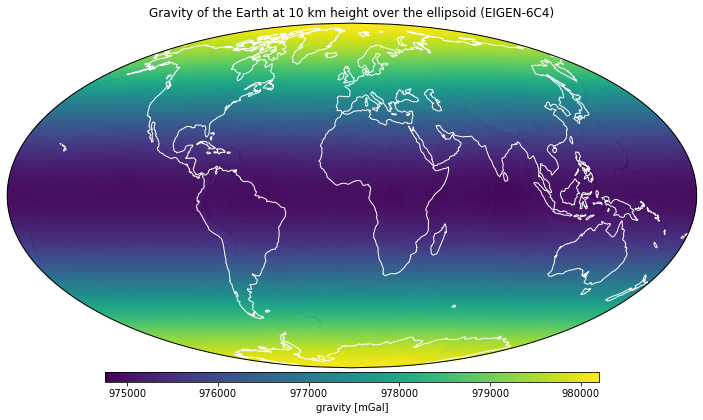

In [15]:
# Use these values to set the colorbar range
gravity_min, gravity_max = gravity.gravity_ell.min(), gravity.gravity_ell.max()

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_title("Gravity of the Earth at 10 km height over the ellipsoid (EIGEN-6C4)")
tmp = ax.pcolormesh(
    gravity.longitude, gravity.latitude, gravity.gravity_ell, 
    transform=ccrs.PlateCarree(), 
    cmap="viridis",
    vmin=gravity_min, vmax=gravity_max,
)
plt.colorbar(tmp, label="gravity [mGal]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.coastlines(color="white")
plt.subplots_adjust(top=0.95, bottom=0, right=0.99, left=0.01, hspace=0, wspace=0)
plt.savefig("gravity-earth.png", dpi=200)
plt.show()

To calculate the disturbance we need first to calculate Normal Gravity at the measurement points (with the same ellipsoidal height). We'll use the WGS84 ellipsoid from the library [Boule](https://www.fatiando.org/boule/latest/) for the calculation.

In [16]:
normal_gravity = bl.WGS84.normal_gravity(gravity.latitude, gravity.height_over_ell)

Now we can plot Normal Gravity as well.

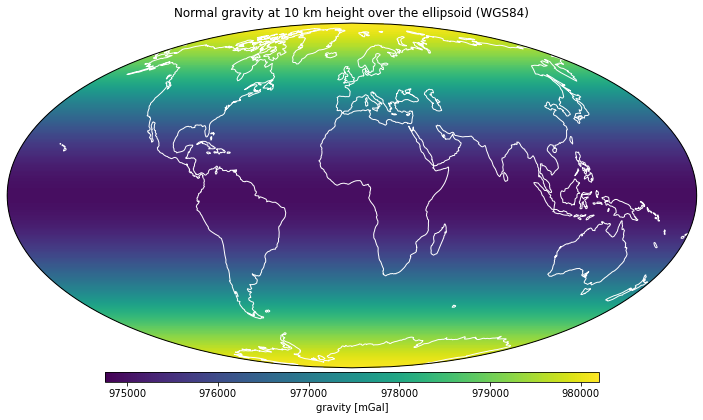

In [17]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_title("Normal gravity at 10 km height over the ellipsoid (WGS84)")
tmp = ax.pcolormesh(
    gravity.longitude, gravity.latitude, normal_gravity, 
    transform=ccrs.PlateCarree(), 
    cmap="viridis",
    vmin=gravity_min, vmax=gravity_max,
)
plt.colorbar(tmp, label="gravity [mGal]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.coastlines(color="white")
plt.subplots_adjust(top=0.95, bottom=0, right=0.99, left=0.01, hspace=0, wspace=0)
plt.savefig("gravity-normal-earth.png", dpi=200)
plt.show()

The disturbance is the difference between the two.

In [18]:
disturbance = gravity.gravity_ell - normal_gravity

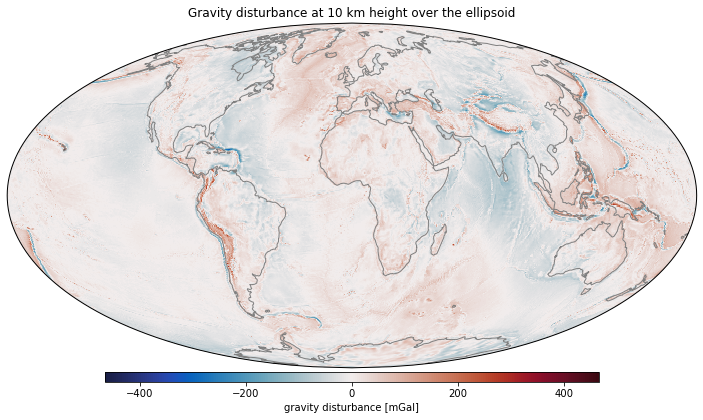

In [19]:
# To center the 0 in the colorbar
maxabs = vd.maxabs(disturbance)

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_title("Gravity disturbance at 10 km height over the ellipsoid")
tmp = ax.pcolormesh(
    disturbance.longitude, disturbance.latitude, disturbance, 
    transform=ccrs.PlateCarree(), 
    cmap=cmocean.cm.balance,
    vmin=-maxabs, vmax=maxabs,
)
plt.colorbar(tmp, label="gravity disturbance [mGal]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.coastlines(color="gray")
plt.subplots_adjust(top=0.95, bottom=0, right=0.99, left=0.01, hspace=0, wspace=0)
plt.savefig("gravity-disturbance.png", dpi=200)
plt.show()

## Gravity disturbance profile

Now we can use our interpolator (with the blocked mean operation) to extract a profile of the gravity disturbance between the same points as our topography profile.

In [20]:
interpolator.fit(np.meshgrid(disturbance.longitude, disturbance.latitude), disturbance.values)

Chain(steps=[('blockmean',
              BlockReduce(adjust='spacing', center_coordinates=False,
                          drop_coords=True,
                          reduction=<function mean at 0x7f33dc89e3a0>,
                          region=None, shape=None, spacing=0.5)),
             ('interpolate', ScipyGridder(extra_args=None, method='nearest'))])

In [21]:
disturbance_profile = interpolator.profile(point1=profile_start, point2=profile_end, size=200)
disturbance_profile.distance *= 111

Plot the profile location first on the disturbance map.

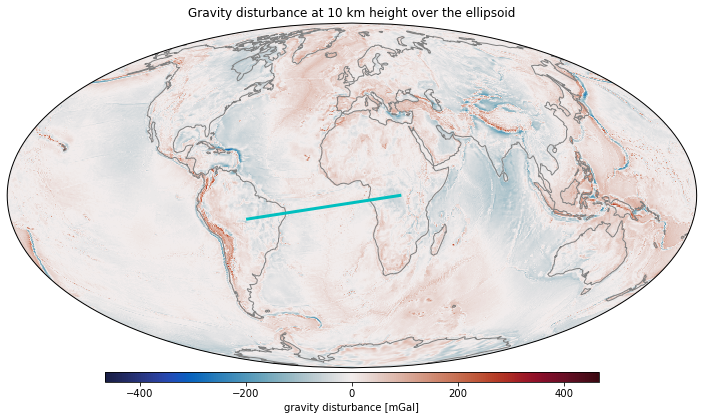

In [22]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_title("Gravity disturbance at 10 km height over the ellipsoid")
tmp = ax.pcolormesh(
    disturbance.longitude, disturbance.latitude, disturbance, 
    transform=ccrs.PlateCarree(), 
    cmap=cmocean.cm.balance,
    vmin=-maxabs, vmax=maxabs,
)
plt.colorbar(tmp, label="gravity disturbance [mGal]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.plot(disturbance_profile.easting, disturbance_profile.northing, "-c", linewidth=3, transform=ccrs.PlateCarree())
ax.coastlines(color="gray")
plt.subplots_adjust(top=0.95, bottom=0, right=0.99, left=0.01, hspace=0, wspace=0)
plt.savefig("gravity-disturbance-profile.png", dpi=200)
plt.show()

Now plot the predicted disturbance and the observed one together. **Do they match?**

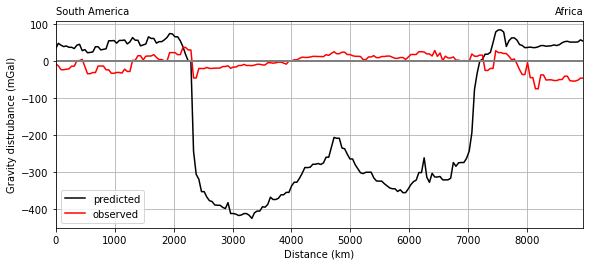

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.text(0, 1.03, "South America", transform=ax.transAxes)
ax.text(1, 1.03, "Africa", horizontalalignment="right", transform=ax.transAxes)
ax.plot(topo_profile.distance, predicted_gravity, "-k", label="predicted")
ax.plot(disturbance_profile.distance, disturbance_profile.scalars, "-r", label="observed")
ax.plot(profile_bounds, [0, 0], "-", color="gray", linewidth=2)
ax.legend()
ax.set_ylabel("Gravity distrubance (mGal)")
ax.grid()
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("gravity-profile-predicted-vs-observed.png", dpi=200)
plt.show()

## Airy-Heiskanen compensantion

A mechanism to explain the why the disturbance is close to 0 is isostatic compensation. We can use the Airy-Heiskanen model to predict the Moho depth given our known topography. Again, we'll use Harmonica to do the calculations.

In [24]:
airy_moho = hm.isostasy_airy(
    topo_profile.scalars * 1000, density_crust=2800, density_mantle=3300, density_water=1040, reference_depth=30e3
)
airy_moho /= -1000
airy_moho

0     -31.582000
1     -32.282000
2     -32.038400
3     -31.856711
4     -31.933867
         ...    
195   -32.439111
196   -32.432889
197   -32.454667
198   -32.727200
199   -32.547067
Name: scalars, Length: 200, dtype: float64

Now we can plot our Airy-isostatic Moho in our profile.

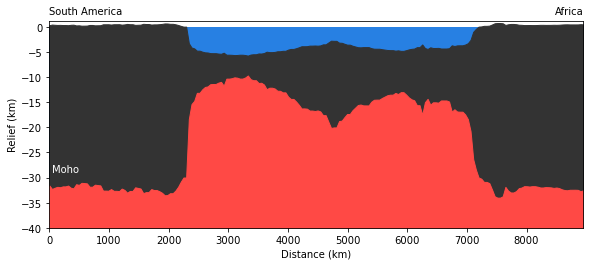

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.text(0, 1.03, "South America", transform=ax.transAxes)
ax.text(1, 1.03, "Africa", horizontalalignment="right", transform=ax.transAxes)
ax.text(50, -29, "Moho", color="white")
ax.fill_between(profile_bounds, [0, 0], moho, color='#2780E3')
ax.fill_between(topo_profile.distance, topo_profile.scalars, airy_moho, color='#333333')
ax.fill_between(topo_profile.distance, airy_moho, max_depth, color='#ff4945')
ax.set_ylabel('Relief (km)')
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.ylim(max_depth, topo_profile.scalars.max() + 0.5)
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("topography-profile-airy.png", dpi=200)
plt.show()

The mid-ocean ridge doesn't look right. That's where we expected the crust to be thinnest.

## Pratt-Hayford compensation

Another compensantion model is the Pratt-Hayford, which seeks isostatic equilibrium by reducing the density of the underlying crust instead of thickenning it. This one is not present in Harmonica so we'll code it ourselves.

First, isolate the mid-ocean ridge part of the profile.

In [26]:
ridge = np.logical_and(topo_profile.distance > 3500, topo_profile.distance < 6000)
ridge_topo = topo_profile.scalars[ridge]
ridge_distance = topo_profile.distance[ridge]

Calculate the predicted density that would result in isostatic equilibrium. This result will vary based on the chosen parameters below.

In [27]:
density_crust = 2800
density_water = 1040
compensation_depth = 30e3
pratt_density = (density_crust*compensation_depth - density_water*ridge_topo*-1e3) / (compensation_depth - ridge_topo*-1e3)

Plot the ridge and associate density variation.

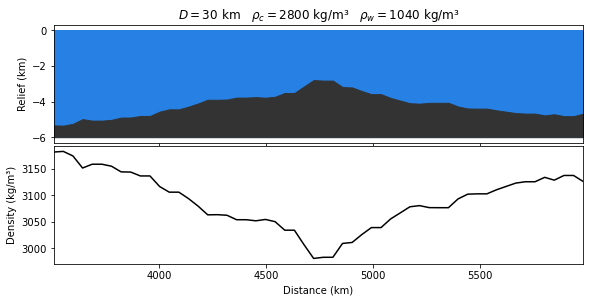

In [28]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 4))

ax = axes[0]
ax.set_title(f"$D = {compensation_depth/1e3:.0f}$ km   $\\rho_c = {density_crust}$ kg/m³   $\\rho_w = {density_water}$ kg/m³")
ax.fill_between([ridge_distance.min(), ridge_distance.max()], [0, 0], -6, color='#2780E3')
ax.fill_between(ridge_distance, ridge_topo, -6, color='#333333')
ax.set_ylabel('Relief (km)')

ax = axes[1]
ax.plot(ridge_distance, pratt_density, "-k")

ax.set_ylabel('Density (kg/m³)')
ax.set_xlabel('Distance (km)')
plt.xlim(ridge_distance.min(), ridge_distance.max())
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("density-pratt.png", dpi=200)
plt.show()

## Histogram of global disturbance

To check if the majority of the relief on the Earth is isostatically compensated, we can plot a histogram of the disturbance. If the relief is compensated, we expect close to 0 disturbance (regardless of the mechanism for compensation).

To avoid long computations, we will coarsen the disturbance grid with blocked mean again.

In [29]:
disturbance_reduced = vd.BlockReduce(np.mean, spacing=0.5).filter(
    np.meshgrid(disturbance.longitude, disturbance.latitude), disturbance.values
)[1]

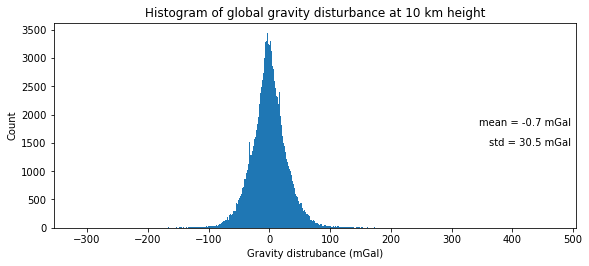

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.set_title("Histogram of global gravity disturbance at 10 km height")
ax.hist(disturbance_reduced, bins="auto")
ax.set_ylabel('Count')
ax.set_xlabel('Gravity distrubance (mGal)')
ax.text(0.99, 0.5, f"mean = {disturbance_reduced.mean():.1f} mGal", horizontalalignment="right", transform=ax.transAxes)
ax.text(0.99, 0.4, f"std = {disturbance_reduced.std():.1f} mGal", horizontalalignment="right", transform=ax.transAxes)
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("disturbance-histogram.png", dpi=200)
plt.show()

So it seems that the majority of the relief is compensated.

## Subduction zones and trenches

Some of the relief that isn't compensated can be found at subduction zones and the associated trenches. Let's take a look at a profile across the trench next to Japan.

First, select only data around Japan.

In [31]:
japan_region = (110, 170, 30, 55)
japan_topo = topo.sel(lon=slice(*japan_region[:2]), lat=slice(*japan_region[2:]))
japan_disturbance = disturbance.sel(longitude=slice(*japan_region[:2]), latitude=slice(*japan_region[2:]))

Now we can do a cubic interpolation for the profile to get a smoother curve.

In [32]:
japan_interp = vd.ScipyGridder(method="cubic")
# Fit the topography
japan_interp.fit(np.meshgrid(japan_topo.lon, japan_topo.lat), japan_topo.values)
japan_profile = japan_interp.profile(point1=(125, 45), point2=(155, 35), size=200)
japan_profile.distance *= 111
japan_profile.scalars /= 1000
# Fit the disturbance
japan_interp.fit(np.meshgrid(japan_disturbance.longitude, japan_disturbance.latitude), japan_disturbance.values)
japan_profile["disturbance"] = japan_interp.profile(point1=(125, 45), point2=(155, 35), size=200).scalars

Make figure with the topography profile and the associated gravity disturbance.

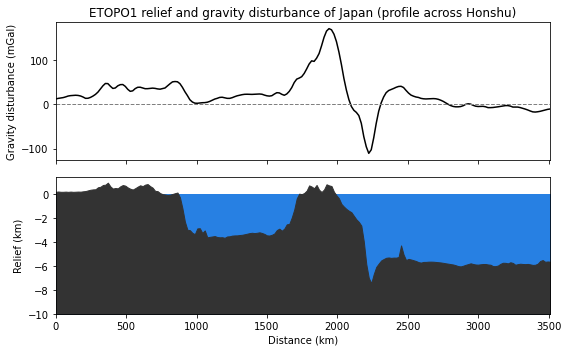

In [33]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
profile_bounds = [japan_profile.distance.min(), japan_profile.distance.max()]

ax = axes[0]
ax.set_title("ETOPO1 relief and gravity disturbance of Japan (profile across Honshu)")
ax.plot(japan_profile.distance, japan_profile.disturbance, "-k")
ax.plot(profile_bounds, [0, 0], "--", color="gray", linewidth=1)
ax.set_ylabel("Gravity disturbance (mGal)")

max_depth = -10
ax = axes[1]
ax.fill_between(profile_bounds, [0, 0], max_depth, color='#2780E3')
ax.fill_between(japan_profile.distance, japan_profile.scalars, max_depth, color='#333333')
ax.set_ylabel('Relief (km)')
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.ylim(max_depth, japan_profile.scalars.max() + 0.5)
plt.tight_layout()
plt.savefig("topography-profile-japan.png", dpi=200)
plt.show()

And plot a topography map with the location of the profile.

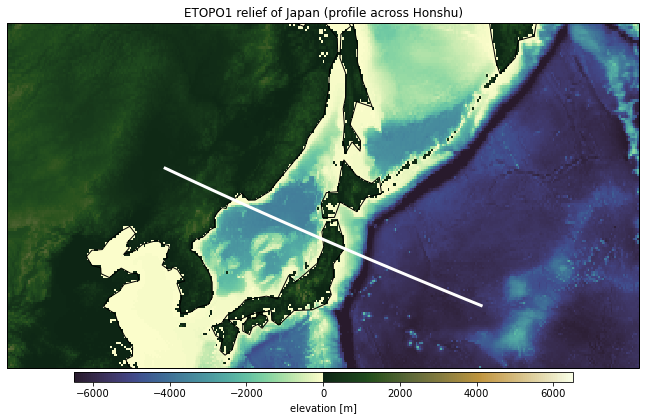

In [34]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_title("ETOPO1 relief of Japan (profile across Honshu)")
tmp = ax.pcolormesh(
    japan_topo.lon, japan_topo.lat, japan_topo.values, 
    transform=ccrs.PlateCarree(), 
    vmin=-6500, vmax=6500, 
    cmap=cmocean.cm.topo
)
plt.colorbar(tmp, label="elevation [m]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.plot(japan_profile.easting, japan_profile.northing, "-w", linewidth=3, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent((110, 170, 30, 50))
plt.subplots_adjust(top=0.95, bottom=0.0, right=1, left=0.01, hspace=0, wspace=0)
plt.savefig("topography-profile-japan-location.png", dpi=200)
plt.show()

## Island chains

Other places that lack local isostatic compensation are oceanlic island chains (usually associated with hotspots). As an example, let's make a similar profile across the island of Oahu in Hawai'i.

In [35]:
hawaii_region = (-180, -140, 12, 32)
hawaii_topo = topo.sel(lon=slice(*hawaii_region[:2]), lat=slice(*hawaii_region[2:]))
hawaii_disturbance = disturbance.sel(longitude=slice(*hawaii_region[:2]), latitude=slice(*hawaii_region[2:]))

In [36]:
hawaii_interp = vd.ScipyGridder(method="cubic")
# Fit the topography
hawaii_interp.fit(np.meshgrid(hawaii_topo.lon, hawaii_topo.lat), hawaii_topo.values)
hawaii_profile = hawaii_interp.profile(point1=(-165, 13), point2=(-151, 29.5), size=200)
hawaii_profile.distance *= 111
hawaii_profile.scalars /= 1000
# Fit the disturbance
hawaii_interp.fit(np.meshgrid(hawaii_disturbance.longitude, hawaii_disturbance.latitude), hawaii_disturbance.values)
hawaii_profile["disturbance"] = hawaii_interp.profile(point1=(-165, 13), point2=(-151, 29.5), size=200).scalars

And now plot the profiles.

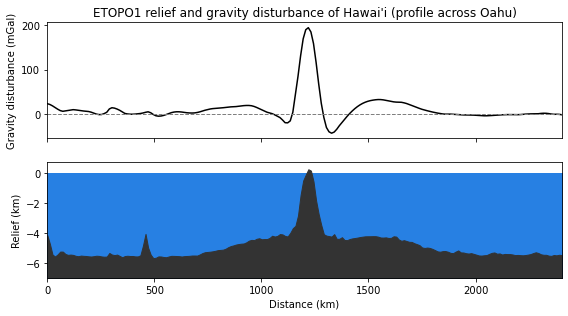

In [37]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 4.5))
profile_bounds = [hawaii_profile.distance.min(), hawaii_profile.distance.max()]

ax = axes[0]
ax.set_title("ETOPO1 relief and gravity disturbance of Hawai'i (profile across Oahu)")
ax.plot(hawaii_profile.distance, hawaii_profile.disturbance, "-k")
ax.plot(profile_bounds, [0, 0], "--", color="gray", linewidth=1)
ax.set_ylabel("Gravity disturbance (mGal)")

max_depth = -7
ax = axes[1]
ax.fill_between(profile_bounds, [0, 0], max_depth, color='#2780E3')
ax.fill_between(hawaii_profile.distance, hawaii_profile.scalars, max_depth, color='#333333')
ax.set_ylabel('Relief (km)')
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.ylim(max_depth, hawaii_profile.scalars.max() + 0.5)
plt.tight_layout()
plt.savefig("topography-profile-hawaii.png", dpi=200)
plt.show()

And a map of the location.

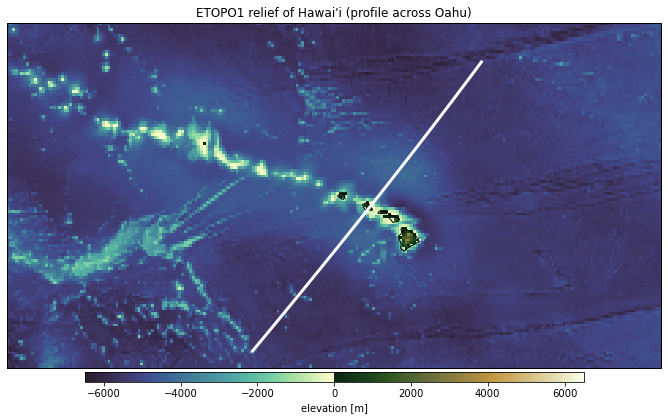

In [38]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_title("ETOPO1 relief of Hawai'i (profile across Oahu)")
tmp = ax.pcolormesh(
    hawaii_topo.lon, hawaii_topo.lat, hawaii_topo.values, 
    transform=ccrs.PlateCarree(), 
    vmin=-6500, vmax=6500, 
    cmap=cmocean.cm.topo
)
plt.colorbar(tmp, label="elevation [m]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.plot(hawaii_profile.easting, hawaii_profile.northing, "-w", linewidth=3, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent((-180, -140, 12, 30))
plt.subplots_adjust(top=0.95, bottom=0.0, right=1, left=0.01, hspace=0, wspace=0)
plt.savefig("topography-profile-hawaii-location.png", dpi=200)
plt.show()

We'll use this profile in the lab so let's save it to a comma-separated text file (CSV).

In [39]:
hawaii_profile_pretty = hawaii_profile.rename(
    columns=dict(northing="latitude", easting="longitude", scalars="topography_km", distance="distance_km", disturbance="disturbance_mgal")
)
hawaii_profile_pretty

,latitude,longitude,distance_km,topography_km,disturbance_mgal
0,13.000000,-165.000000,0.000000,-4.161000,23.008098
1,13.082915,-164.929648,12.070042,-4.747907,21.180807
2,13.165829,-164.859296,24.140085,-5.452608,18.099661
3,13.248744,-164.788945,36.210127,-5.581402,14.372280
4,13.331658,-164.718593,48.280170,-5.438978,10.606283
...,...,...,...,...,...
195,29.168342,-151.281407,2353.658266,-5.539440,-0.359882
196,29.251256,-151.211055,2365.728309,-5.481472,-0.993508
197,29.334171,-151.140704,2377.798351,-5.503901,-0.858798
198,29.417085,-151.070352,2389.868394,-5.467104,-1.044911


In [40]:
hawaii_profile_pretty.to_csv("../../labs/data/hawaii-profile.csv", index=False)